In [1]:
%load_ext autoreload
%autoreload 2

import os 
import pandas as pd
from bpreg.scripts.bpreg_inference import bpreg_inference
from docs.notebooks.utils import * 

# Crop Lungs from dataset
Imagine we created a deep learning network which analyzes a specific lung disease. We want to apply the network now on a new dataset. To preprocess the dataset, we need to do two things: 
1. Filter all volumes, where the lungs are present
2. Crop the lungs from the volume

In this tutorial we will go through the preprocessing, and it will be explained how the bpreg package can help us. 


## 1. Download Data
For this tutorial, a subset of the [TCGA-KIRC ](https://wiki.cancerimagingarchive.net/display/Public/TCGA-KIRC#580038695f8cd691bda43dda71b4093c69c7318)
dataset from the TCIA is used. The DICOM files were transformed to nifti files. To save the information in the DICOM metadata, an additional meta-data file was created with the metadata inside. 
Moreover, to reduce the size of the dataset and to remove CT scans with few slices, nifti files with a size greater than 35 MB and smaller than 5 MB were removed. 

Please download the data from Zenodo: <br>
https://zenodo.org/record/5141950#.YQFiMNaxWEA


## 2. Analyze dataset
Firs, we want to analyze the dataset from Zenodo.



In [2]:
input_path = "data/TCGA-KIRC/TCGA-KIRC_nifti"
meta_data =  "data/TCGA-KIRC/TCGA-KIRC_meta_data.xlsx"
output_path = "data/TCGA-KIRC/TCGA-KIRC_json"

if not os.path.exists(output_path): os.mkdir(output_path)

In [3]:
print(f"The dataset contains: {len(os.listdir(input_path))} CT volumes.")

The dataset contains: 291 CT volumes.



## 2.1  Analyze DICOM tag BodyPartExamined
One approach to obtain the Examined Body Part from a CT volume is to analyze the DICOM tag BodyPartExamined. Unfortunately, the tag is not very precise and often misleading or empty. 



,Proportion [%]
BodyPartExamined,
Kidney,56.3
KIDNEY,43.7


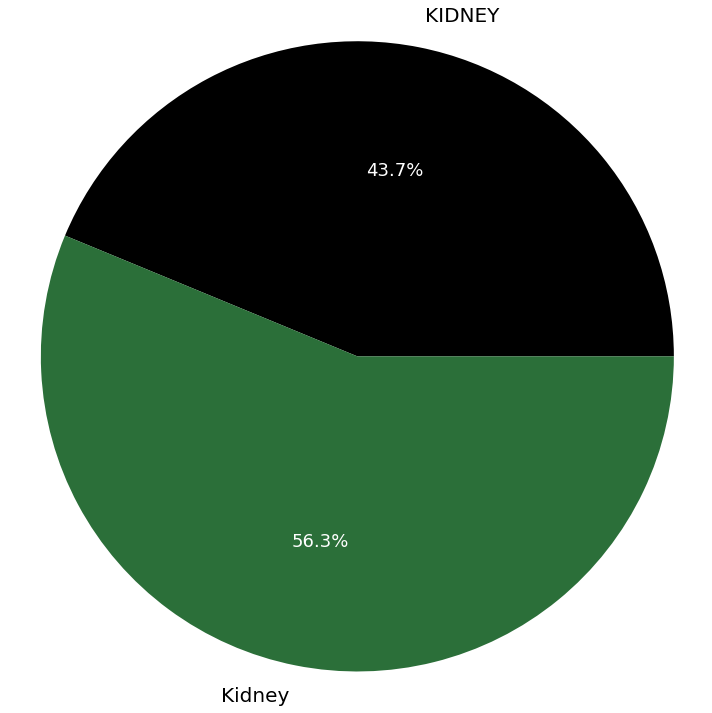

In [4]:
df = pd.read_excel(meta_data)
plot_dicomexamined_distribution(df, column="BodyPartExamined", count_column="filepath")

## 3. Body Part Regression Inference
We can create for every nifti file a corresponding json output file. The json file contains metadata to the examined body part. Moreover, in the output path an additional `README.md` file is saved, where the metadata inside the json-files is explained. 



In [5]:
bpreg_inference(input_path, output_path)

JSON-file already exists. Skip file: TCGA-B8-4154_07-27-2003-CT-ABDOMEN-PELVIS-W-CONT-78543_2.000000-AbdPelvis--5.0--B31f-92442_.nii.gz
JSON-file already exists. Skip file: TCGA-B8-5551_02-18-2004-CT-RENAL-Mass-79313_3.000000-Arterial--5.0--B31f-51058_.nii.gz
JSON-file already exists. Skip file: TCGA-B8-4151_05-19-2003-CT-RENAL-Mass-57015_2.000000-Unenhanced---5.0--B30f-16470_.nii.gz
JSON-file already exists. Skip file: TCGA-B8-5162_10-06-2003-CT-RENAL-Mass-58198_3.000000-Arterial-Phase--5.0--B30f-49138_.nii.gz
JSON-file already exists. Skip file: TCGA-CW-6096_04-02-1995-Abdomen020APRoutine-Adult-68078_2.000000-kids-wo--5.0--B40s-64573_.nii.gz
JSON-file already exists. Skip file: TCGA-CW-5589_07-24-1992-Abdomen01AbdPelvisRoutine-Adult-36102_6.000000-3-min-delay--5.0--B40f-40093_.nii.gz
JSON-file already exists. Skip file: TCGA-B0-5117_01-16-1989-ABD-RENAL-STONE-96405_2.000000-Helical-5s-89466_.nii.gz
JSON-file already exists. Skip file: TCGA-CW-6096_02-07-1992-Abdomen1-AP-ROUTINE-85865

JSON-file already exists. Skip file: TCGA-B8-4154_08-13-2003-UROGRAM-CT-57460_4.000000-Contrast--5.0--B31f-13688_.nii.gz
JSON-file already exists. Skip file: TCGA-CW-5585_02-23-1997-Thorax040CAPRoutine-Adult-01591_5.000000-MIP-Axial-Chest-40365_.nii.gz
JSON-file already exists. Skip file: TCGA-CW-6093_05-17-1991-Abdomen06CTAAbdomenPostEVT-Adult-10219_2.000000-WO-Abd.---5.0--B40f-55576_.nii.gz
JSON-file already exists. Skip file: TCGA-CW-5589_07-24-1992-Abdomen01AbdPelvisRoutine-Adult-36102_4.000000-APRoutine--5.0--B40f-31576_.nii.gz
JSON-file already exists. Skip file: TCGA-B8-4622_01-11-2004-CT-CHEST-WO-CONTRAST-80068_2.000000-ChestAbd--5.0--B31f-78583_.nii.gz
JSON-file already exists. Skip file: TCGA-B8-4620_05-09-2002-CT-RENAL-Mass-57135_2.000000-NonContrast--5.0--B30f-99725_.nii.gz
JSON-file already exists. Skip file: TCGA-B8-4151_05-19-2003-CT-RENAL-Mass-57015_5.000000-Venous-Phase--5.0--B30f-38289_.nii.gz
JSON-file already exists. Skip file: TCGA-CW-6090_08-03-1991-Abdomen1-AP-RO

## 4. Analyze
Let's analyze the json metadata files. In each json file, several tags are saved. 

## 4.1 Slice Scores
We can for example plot the slice scores. The slice scores increase monotonously with slice height. With the help of the `look-up table` the slice scores can be mapped to concrete anatomies. 

## 4.2 Body Part Examined tag
The body part examined tag is based on the predicted slice scores. For each volume, one tag is calculated. If the slope of the slice scores seem unrealistic, the tag is equal to NONE. 



In [6]:
json_filepaths = [os.path.join(output_path, f) for f in os.listdir(output_path) if f.endswith(".json")]
nifti_filepaths = [os.path.join(input_path, f.replace(".json", ".nii.gz")) for f in os.listdir(output_path)]

x = load_json(json_filepaths[0])
x.keys()

dict_keys(['cleaned slice scores', 'z', 'unprocessed slice scores', 'body part examined', 'body part examined tag', 'look-up table', 'reverse z-ordering', 'valid z-spacing', 'expected slope', 'observed slope', 'slope ratio', 'expected z-spacing', 'z-spacing', 'settings'])

In [7]:
plot_scores_interactive(json_filepaths, nifti_filepaths)

interactive(children=(BoundedFloatText(value=0.0, description='JSON file:', max=288.0, step=1.0), Output()), _…

,Proportion [%]
tag,
ABDOMEN,37.0
ABDOMEN-PELVIS,27.7
NONE,22.5
CHEST,4.5
CHEST-ABDOMEN,2.8
CHEST-ABDOMEN-PELVIS,2.8
PELVIS,1.0
HEAD-NECK-CHEST-ABDOMEN,0.7
NECK-CHEST,0.7


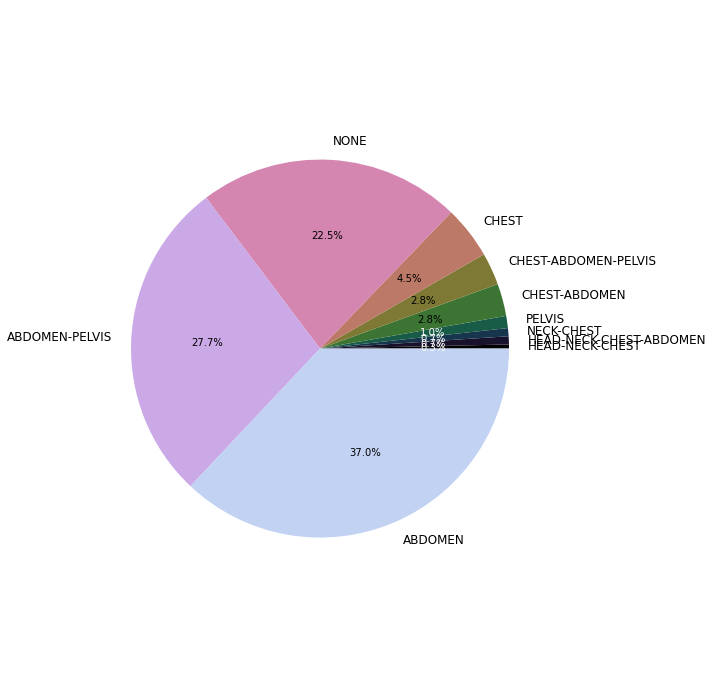

In [8]:
dftags = get_updated_bodypartexamined_from_json_files(output_path)
plot_dicomexamined_distribution(dftags, fontsize=12)

Based on the Body Part Examined tag, we are able to filter all CT volumes, where the CHEST is present. 

In [9]:
# Filter files which include the chest
dfchest = dftags[dftags.tag.isin(["CHEST", "CHEST-ABDOMEN-PELVIS", "CHEST-ABDOMEN"])]
dfchest.reset_index(drop=False, inplace=True)
dfchest = dfchest.rename({"index": "json"}, axis=1)
dfchest = dfchest.drop(["count"], axis=1)
print(f"Files which include the chest: {dfchest.shape[0]}")
dfchest.sample(5)

Files which include the chest: 29


,json,tag
7,TCGA-B0-4845_02-25-1986-CT-CAP-WO-WITH-29227_3...,CHEST-ABDOMEN-PELVIS
26,TCGA-B8-5163_11-18-2003-CT-CHEST---WCONTRAST-1...,CHEST
4,TCGA-B0-4845_12-24-1985-CT-CAP-WO-WITH-72944_3...,CHEST-ABDOMEN-PELVIS
9,TCGA-CW-5587_04-30-1993-Thorax02CAPRoutine-Adu...,CHEST-ABDOMEN-PELVIS
25,TCGA-B0-4712_08-04-1991-CAP-WO-63405_2.000000-...,CHEST-ABDOMEN-PELVIS


## 5. Crop the lungs
For the remaining CT volumes, we can crop the lungs by finding the expected scores for the landmark `lung_start` and `lung_end`. With these score boundaries, the appropriate region can be cropped in the CT volumes based on the slice score curves. 



In [10]:
x = load_json(json_filepaths[0])
lookuptable = pd.DataFrame(x["look-up table"]).T
start_score = x["look-up table"]["lung_start"]["mean"]
end_score = x["look-up table"]["lung_end"]["mean"]

lookuptable.sort_values(by="mean")[["mean"]]

,mean
pelvis_start,0.000
femur_end,13.616
L5,25.532
pelvis_end,28.824
L4,29.414
L3,33.817
kidney,37.597
L2,37.763
L1,41.478
lung_start,44.143


In [11]:
plot_tailored_volumes_interactive(dfchest, 
                                  start_score, 
                                  end_score, 
                                  json_base_path=output_path, 
                                  nifti_base_path=input_path)

interactive(children=(BoundedFloatText(value=0.0, description='JSON file:', max=28.0, step=1.0), Output()), _d…